# Finetuning model with Norwegian Index ("microsoft/Phi-3-mini-4k-instruct")

Sources:
- https://www.kaggle.com/code/aisuko/fine-tuning-t5-small-with-lora 
- https://github.com/philschmid/deep-learning-pytorch-huggingface/blob/main/training/flan-t5-samsum-summarization.ipynb

Import libraries

In [16]:
import json
import torch
from matplotlib import pyplot as plt
from datasets import load_dataset, concatenate_datasets
from transformers import (AutoConfig, AutoModelForSeq2SeqLM, AutoTokenizer, Seq2SeqTrainer,
                          Seq2SeqTrainingArguments, DataCollatorForSeq2Seq)
import random
seed = 42
random.seed(seed)

model_name = "MBZUAI/LaMini-Flan-T5-248M"
#model_name = "MBZUAI/LaMini-Flan-T5-783M"

# Finetuning paraphrase + intra

- Load training and evaluation data
- Load t5 model with pretrained weights
- Format data to train

### Training Inter-Chapter & Instra-Chapter

In [2]:
train_intra = load_dataset("json", data_files="Data/TrainData/intra_chapter_dataset.jsonl",split="train")
train_paraphrase = load_dataset("json", data_files="Data/TrainData/paraphrase_dataset.jsonl",split="train")

print(f"train_intra\n{train_intra}\n")
print(f"train_paraphrase\n{train_paraphrase}\n")

# Validation
val_intra = load_dataset("json", data_files="Data/ValData/intra_chapter_dataset.jsonl",split="train")
val_paraphrase = load_dataset("json", data_files="Data/ValData/paraphrase_dataset.jsonl",split="train")

# Combined datasets
train_dataset = concatenate_datasets([train_intra, train_paraphrase])
val_dataset = concatenate_datasets([val_intra, val_paraphrase])

print(f"train_dataset\n{train_dataset}\n")
print(f"val_dataset\n{val_dataset}")

train_intra
Dataset({
    features: ['QandA'],
    num_rows: 4785
})

train_paraphrase
Dataset({
    features: ['QandA'],
    num_rows: 5680
})

train_dataset
Dataset({
    features: ['QandA'],
    num_rows: 10465
})

val_dataset
Dataset({
    features: ['QandA'],
    num_rows: 1136
})


### Sample Weighted Training

Trainable parameters: 178151424
Train size: 10465
Validation size: 1136
Max question length: 111
Max answer length: 848


Map: 100%|██████████| 10465/10465 [00:14<00:00, 728.71 examples/s]
/home/erik/Desktop/MVP/.venv/lib64/python3.13/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(



Decoded first example from dataset:
Question: Instruction: Based on the situation description, identify the most relevant medical chapter and give detailed, structured medical advices.
 Input: previously experienced anaphylactic shock due to specific insect, allergy history, risk of severe reaction</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
Answer: # Relevant Chapters:
 - 17 Bite / insect sting

 ## IMPORTANT INFORMATION TO THE CALLER
 - Help is on the way. I may need to phone you back, so keep this phone free until the medics arrive.
 - Watch the person all the time. Tell me immediately if anything changes.

 ## SAFETY AT THE SCENE
 - Keep out of danger and always ensure the safety of others.
 - If poss

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss,Validation Loss
500,10.958200,4.777703
1000,5.448000,3.031926
1500,4.043200,2.258586
2000,3.229000,1.740647
2500,2.567200,1.427519
3000,2.158900,1.219647
3500,1.789200,1.101437
4000,1.612000,0.930065
4500,1.389600,0.804416
5000,1.265500,0.723218


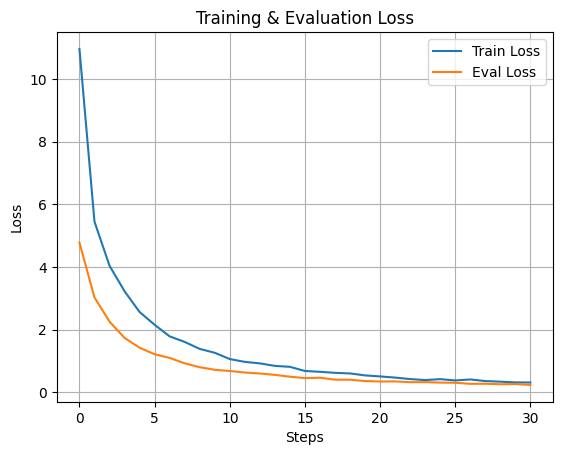

Losses saved to ./Data/Plots/weighted-intra-paraphrase-MBZUAI-LaMini-Flan-T5-783M-finetuned (ep=3, bs=1, lr=0.0005, wd=0.001, grad_acc=2).json


In [ ]:
bs = 1
lr = 5e-4
epochs = 3
wd = 0.001
log_steps = 500
gradient_accumulation_steps = 2
max_context_length = 1024
last_layer_train = True

output_dir = f"./Models/weighted-intra-paraphrase-{model_name}-finetuned (ep={epochs}, bs={bs}, lr={lr}, wd={wd}, grad_acc={gradient_accumulation_steps}"

config = AutoConfig.from_pretrained(model_name)
config.dropout_rate = 0.3
config.max_position_embeddings = max_context_length

# Load model and tokenizer
model = AutoModelForSeq2SeqLM.from_pretrained(
	model_name,
	config=config,
	device_map="auto",
)

if last_layer_train:

	enc_unfreeze_start = 18   # unfreeze encoder blocks 18–23 (last 6 layers)
	dec_unfreeze_start = 20   # unfreeze decoder blocks 20–23 (last 4 layers)

	output_dir += f", last_enc_layers={24-enc_unfreeze_start}, last_dec_layers={24-dec_unfreeze_start})"

	for name, param in model.named_parameters():
		if any(f"encoder.block.{i}" in name for i in range(enc_unfreeze_start, 24)):
			param.requires_grad = True
		elif any(f"decoder.block.{i}" in name for i in range(dec_unfreeze_start, 24)):
			param.requires_grad = True
		elif "lm_head" in name:
			param.requires_grad = True
		else:
			param.requires_grad = False

else:
	output_dir += ")"

num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {num_trainable_params}")
print("=" * 50)

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.add_special_tokens({"additional_special_tokens": ["æ", "ø", "å", "\n"]})
tokenizer.model_max_length = max_context_length
model.resize_token_embeddings(len(tokenizer))

print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")

max_train_question_length = max(len(tokenizer(sample["QandA"][0]["content"], truncation=True)['input_ids']) for sample in train_dataset)
max_train_answer_length = max(len(tokenizer(sample["QandA"][1]["content"], truncation=True)['input_ids']) for sample in train_dataset)

max_val_question_length = max(len(tokenizer(sample["QandA"][0]["content"], truncation=True)['input_ids']) for sample in val_dataset)
max_val_answer_length = max(len(tokenizer(sample["QandA"][1]["content"], truncation=True)['input_ids']) for sample in val_dataset)

max_question_length = max(max_train_question_length, max_val_question_length)
max_answer_length = max(max_train_answer_length, max_val_answer_length)

print(f"Max question length: {max_question_length}")
print(f"Max answer length: {max_answer_length}")


def formatting_prompts_func(sample):
	QA = sample["QandA"]  # List with user and assistant responses
	symptoms = QA[0]['content'].strip()
	answer = QA[1]['content'].strip()

	
	question = (
		"Instruction: Based on the situation description, identify the most relevant medical chapter "
		"and give detailed, structured medical advices.\n"
		f"Input: {symptoms}"
	)


	# Tokenize question (inputs)
	tokens = tokenizer(question, max_length=max_question_length, padding="max_length", truncation=True)
	# Tokenize answer (targets)
	answer_enc = tokenizer(text_target=answer, max_length=max_answer_length, padding="max_length", truncation=True)
	# Replace pad tokens with -100 for the labels so that loss is not computed on them
	labels = [-100 if token_id == tokenizer.pad_token_id else token_id for token_id in answer_enc["input_ids"]]
	tokens["labels"] = labels

	advice_sample_weight = QA[1]['advice_sample_weight']
	chapter_sample_weight = QA[1]['chapter_sample_weight']

	sample_weight = 0.6 * advice_sample_weight + 0.4 * chapter_sample_weight
	tokens["sample_weight"] = sample_weight

	return tokens

val_dataset = val_dataset.map(formatting_prompts_func, batched=False).remove_columns(["QandA"])
train_dataset = train_dataset.map(formatting_prompts_func, batched=False).remove_columns(["QandA"])
train_dataset = train_dataset.shuffle(seed=seed)


class DataCollatorForSeq2SeqWithWeights(DataCollatorForSeq2Seq):
	def __call__(self, features):
		sample_weights = [feature.pop("sample_weight") for feature in features]
		batch = super().__call__(features)
		batch["sample_weight"] = torch.tensor(sample_weights, dtype=torch.float)
		return batch


# Data collator
data_collator = DataCollatorForSeq2SeqWithWeights(
	tokenizer=tokenizer,
	model=model,
	label_pad_token_id=-100,
	pad_to_multiple_of=8
)

class CustomTrainer(Seq2SeqTrainer):
	def __init__(self, *args, **kwargs):
		super().__init__(*args, **kwargs)
		self.train_losses = [] 
		self.eval_losses = []

	def log(self, logs, *args, **kwargs):
		if "loss" in logs:
			self.train_losses.append(logs["loss"])

		if "eval_loss" in logs:
			self.eval_losses.append(logs["eval_loss"])

		super().log(logs, *args, **kwargs)

	def get_train_losses(self):
		return self.train_losses
	
	def get_eval_losses(self):
		return self.eval_losses
	

	def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
		sample_weight = inputs.pop("sample_weight", None)
	
		if sample_weight is None:
			raise ValueError("sample_weight must be provided.")

		outputs = model(**inputs)
		loss = outputs.loss
		weighted_loss = (loss * sample_weight.to(loss.device)).mean()

		return (weighted_loss, outputs) if return_outputs else weighted_loss


# Training arguments
training_args = Seq2SeqTrainingArguments(
	per_device_train_batch_size=bs,
	predict_with_generate=True,
	num_train_epochs=epochs,
	logging_steps=log_steps,

	evaluation_strategy="steps",
	eval_steps=log_steps,
	
	learning_rate=lr,
	weight_decay=wd,
	lr_scheduler_type="constant",
	optim="paged_adamw_32bit",
	gradient_accumulation_steps=gradient_accumulation_steps,
	save_strategy="no",
	
	#save_strategy="steps",
	#load_best_model_at_end=True,
	remove_unused_columns=False,
)

trainer = CustomTrainer(
	model=model,
	train_dataset=train_dataset,
	eval_dataset=val_dataset,
	args=training_args,
	data_collator=data_collator,
)

# Inspect the first training batch
dataloader = trainer.get_train_dataloader()
batch = next(iter(dataloader))

input_ids = batch["input_ids"][0]
label_ids = batch["labels"][0][batch["labels"][0] != -100]

print("\nDecoded first example from dataset:")
question_text = tokenizer.decode(input_ids, max_length=max_question_length, skip_special_tokens=False, clean_up_tokenization_spaces=False)
answer_text = tokenizer.decode(label_ids, max_length=max_answer_length, skip_special_tokens=False, clean_up_tokenization_spaces=False)
print("Question:", question_text)
print("Answer:", answer_text)
print("_"*100)

# Also inspect the batch from dataloader
print("Inspect dataset sent to training:")
print("Question_tokens:", input_ids)
print("Answer_tokens:", label_ids)

# Train the model
trainer.train()
trainer.save_model(output_dir)  # This saves the model and config
tokenizer.save_pretrained(output_dir)  # This saves the tokenizer files

# Plot training loss curve
train_losses = trainer.get_train_losses()
eval_losses = trainer.get_eval_losses()

plt.plot(train_losses, label="Train Loss")
plt.plot(range(0, len(train_losses), len(train_losses) // len(eval_losses)), eval_losses, label="Eval Loss")
plt.title('Training & Evaluation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

losses_dict = {
	"train_losses": train_losses,
	"eval_losses": eval_losses
}
# Save the dictionary to a JSON file
losses_file_path = f'./Data/Plots/weighted-intra-paraphrase-{model_name.replace("/","-")}-finetuned (ep={epochs}, bs={bs}, lr={lr}, wd={wd}, grad_acc={gradient_accumulation_steps}, log_steps={log_steps}).json'
with open(losses_file_path, 'w') as f:
	json.dump(losses_dict, f, indent=2)
print(f"Losses saved to {losses_file_path}")

### Plotting

In [1]:
import re
def extract_params(file_path):
	# Extract parameters from the peft_model_path
	params_string = re.search(r"\((.*?)\)", file_path).group(1)
	params = dict(re.findall(r"(\w+)=([^\s,]+)", params_string))
	for key, value in params.items():
		if value.isdigit():
			params[key] = int(value)
		else:
			try:
				params[key] = float(value)
			except ValueError:
				pass
	return params

In [ ]:
from matplotlib.ticker import MultipleLocator

# Path to your saved JSON
# losses_file_path = './Data/Plots/intra-paraphrase-MBZUAI-LaMini-Flan-T5-248M-finetuned (ep=1, bs=1, lr=0.001, wd=0.005, grad_acc=8).json'
# losses_file_path = "./Data/Plots/weighted-intra-paraphrase-MBZUAI-LaMini-Flan-T5-248M-finetuned (ep=3, bs=1, lr=0.0005, wd=0.001, grad_acc=2).json"
losses_file_path = "./Data/Plots/weighted-intra-paraphrase-MBZUAI-LaMini-Flan-T5-783M-finetuned (ep=3, bs=1, lr=0.0005, wd=0.001, grad_acc=2, log_steps=500).json"

params = extract_params(losses_file_path)
hyperparams = f"Hyperparameters:\n\nmodel={model_name}\nepochs={params["ep"]}\nbatch_size={params["bs"]}\nlearning_rate={params["lr"]}\nweight_decay={params["wd"]}\ngradient_accumulation_steps={params["grad_acc"]}\nlog_steps={params["log_steps"]}"

with open(losses_file_path, 'r') as f:
	losses_dict = json.load(f)

train_losses = losses_dict["train_losses"]
eval_losses = losses_dict["eval_losses"]

# Compute x values in terms of real training steps
x_values = [i * params["log_steps"] for i in range(1, len(train_losses) + 1)]

# Plotting
plt.figure(figsize=(10, 7))
plt.plot(x_values, train_losses, label='Training Loss', color='#1f77b4', linewidth=2.5, marker='o', markersize=6)
plt.plot(x_values, eval_losses, label='Validation Loss', color='#ff7f0e', linewidth=2.5, marker='s', markersize=6)

plt.title('Training vs Validation Loss', fontsize=18, fontweight='bold', pad=20)

# Add hyperparameters text box
plt.gcf().text(0.4, 0.75, hyperparams, fontsize=13, va='top', ha='left', linespacing=2)

plt.xlabel('Training Steps', fontsize=14)
plt.ylabel('Loss', fontsize=14)

# Use MultipleLocator to set the x-ticks to multiples 
plt.gca().xaxis.set_major_locator(MultipleLocator(params["log_steps"]*2))

plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(fontsize=12, loc='upper right')
plt.tight_layout()
plt.show()


### Loading trained model

In [1]:
import json
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from datasets import load_dataset, concatenate_datasets

#model_path = "./Models/weighted-intra-paraphrase-MBZUAI/LaMini-Flan-T5-783M-finetuned (ep=3, bs=1, lr=0.0005, wd=0.001, grad_acc=2, last_enc_layers=6, last_dec_layers=4)"
model_path = "./Models/weighted-intra-paraphrase-MBZUAI/LaMini-Flan-T5-248M-finetuned (ep=3, bs=1, lr=0.0005, wd=0.001, grad_acc=2)"
model = AutoModelForSeq2SeqLM.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.eval()
model.to(device)

/home/erik/Desktop/MVP/.venv/lib64/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


T5ForConditionalGeneration(
  (shared): Embedding(32104, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32104, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.3, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
              (wo):

### Evaluation

In [2]:
import evaluate
rouge = evaluate.load("rouge")
bleu = evaluate.load("bleu")
meteor = evaluate.load("meteor")
f1_metric = evaluate.load("f1")

[nltk_data] Downloading package wordnet to /home/erik/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/erik/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/erik/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


test dataset

In [28]:
test_intra = load_dataset("json", data_files="Data/TestData/intra_chapter_dataset.jsonl", split="train")
test_paraphrase = load_dataset("json", data_files="Data/TestData/paraphrase_dataset.jsonl", split="train")
test_dataset = concatenate_datasets([test_intra, test_paraphrase])
print(f"test_dataset\n{test_dataset}")

display(test_dataset[0])

test_dataset
Dataset({
    features: ['QandA'],
    num_rows: 1136
})


{'QandA': [{'role': 'user',
   'content': 'Symptoms: Numbness or paralysis in various body parts, fatigue, decreased alertness, sensory issues like tingling, and a decline in consciousness following a diving session, all developing within a day.\nCause: Potential decompression sickness or barotrauma resulting from scuba diving.',
   'chapter': None,
   'original_advices': None,
   'advice_sample_weight': None,
   'chapter_sample_weight': None},
  {'role': 'assistant',
   'content': "# Relevant Chapters: \n- 09 Scuba diving accident\n\n## IMPORTANT INFORMATION TO THE CALLER\n- Help is on the way. I may need to phone you back, so keep this phone free until the medics arrive.\n- Watch the casualty all the time. Tell me immediately if anything changes.\n\nNB!\n- Take care of all valves and tanks.\n- You need to send the diver's log, depth gauge and dive computer with the casualty if possible.\n\n## SAFETY AT THE SCENE\n- Keep out of danger and always ensure the safety of others.\n- If poss

Vague dataset

In [3]:
test_dataset = load_dataset("json", data_files="Data/TestData/vague_data.jsonl", split="train")

def formatting_prompts_func(examples):
	QandA_list = []
	for input_text, label in zip(examples["input_text"], examples["label"]):
		input_text = (
			"Instruction: Based on the situation description, identify the most relevant medical chapter "
			"and give detailed, structured medical advices.\n"
			f"Input: {input_text}"
		)

		QandA = [
            {
                "role": "user",
                "content": input_text,
            },
            {
                "role": "assistant",
                "content": str(label),
            }
        ]

		QandA_list.append(QandA)

	return {"QandA": QandA_list}

test_dataset = test_dataset.map(formatting_prompts_func, batched=True).remove_columns(["label", "input_text"])

print(f"test_dataset\n{test_dataset}")
display(test_dataset[1])

Map: 100%|██████████| 35/35 [00:00<00:00, 14758.28 examples/s]

test_dataset
Dataset({
    features: ['QandA'],
    num_rows: 35
})


{'QandA': [{'content': "Instruction: Based on the situation description, identify the most relevant medical chapter and give detailed, structured medical advices.\nInput: Condition: In distressed, pointing at the their upper chest or neck\nObservations: Their respiration comes in irregular bursts, with noticeable gaps between each inhale; eyes flicker nervously around the surroundings; brief, dry coughs break the silence, usually chatty but now mostly quiet\nCause: Had a meal not long ago, though it's uncertain if that's related",
   'role': 'user'},
  {'content': '4', 'role': 'assistant'}]}

In [4]:
import re
from tqdm import tqdm  
from torch.utils.data import DataLoader

def extract_first_number(text):
	match = re.search(r'\b\d+\b', text)
	if match:
		return match.group().strip()
	return ""

BATCH_SIZE = 1
input_texts = []
references = []
predictions = []

for entry in test_dataset:
	QandA = entry["QandA"]
	symptoms = QandA[0]["content"]
	label = QandA[1]["content"]
	
	input_text = (
		"Instruction: Based on the situation description, identify the most relevant medical chapter "
		"and give detailed, structured medical advices.\n"
		f"Input: {symptoms}"
	)

	input_texts.append(input_text)
	references.append(extract_first_number(label.strip()))

# Create batches manually
dataloader = DataLoader(list(zip(input_texts, references)), batch_size=BATCH_SIZE)

# Run inference
for batch in tqdm(dataloader, desc="Running Batched Evaluation (Inference) on Test Data"):
	batch_input_texts, batch_labels = batch

	# Tokenize entire batch
	inputs = tokenizer(list(batch_input_texts), padding=True, truncation=True, return_tensors="pt").to(device)

	# Generate outputs
	with torch.no_grad():
		outputs = model.generate(
			**inputs,
			max_length=50,
			do_sample=False,
		)

	default_special_token_ids = tokenizer.convert_tokens_to_ids([token for token in tokenizer.special_tokens_map.values() if not isinstance(token, list)])

	for output in outputs:
		filtered_tokens = [token for token in output if token not in default_special_token_ids]
		decoded_output = tokenizer.decode(filtered_tokens, skip_special_tokens=False, clean_up_tokenization_spaces=True)
		prediction = extract_first_number(decoded_output.strip())
		predictions.append(prediction)

# Prepare data for saving
output_data = {
    #"input_texts": input_texts,
    "references": references,
    "predictions": predictions
}

# Save the data to a JSON file
output_file = "./Data/Evaluation/VagueTest" + model_path.replace("./Models/","").replace("/", "-") + ".json"

with open(output_file, "w") as f:
    json.dump(output_data, f, indent=4)

print(f"Inference results saved to {output_file}")

Running Batched Evaluation (Inference) on Test Data: 100%|██████████| 35/35 [00:07<00:00,  4.46it/s]

Inference results saved to ./Data/Evaluation/VagueTestweighted-intra-paraphrase-MBZUAI-LaMini-Flan-T5-248M-finetuned (ep=3, bs=1, lr=0.0005, wd=0.001, grad_acc=2).json


### Extract chapter numbers from references and predictions

In [8]:
def extract_first_number(text):
	match = re.search(r'\b\d+\b', text)
	if match:
		return match.group().strip()
	return ""

In [19]:
import json
output_file = "./Data/Evaluation/" + model_path.replace("./Models/","").replace("/", "-") + ".json"
print(output_file)
with open(output_file, "r") as f:
	data = json.load(f)

input_texts = data["input_texts"]
references = data["references"]
predictions = data["predictions"]

print("number of samples in the dataset:", len(input_texts))

./Data/Evaluation/weighted-intra-paraphrase-MBZUAI-LaMini-Flan-T5-248M-finetuned (ep=3, bs=1, lr=0.0005, wd=0.001, grad_acc=2).json
number of samples in the dataset: 1136


In [ ]:
# Compute ROUGE
results = rouge.compute(predictions=predictions, references=references)
meteor_score = meteor.compute(predictions=predictions, references=references)

# ROUGE
rouge_results = rouge.compute(predictions=predictions, references=references)
print("🔹 ROUGE Results:")
for metric, score in rouge_results.items():
    print(f"{metric}: {score:.4f}")
    
# BLEU
bleu_results = bleu.compute(predictions=predictions, references=[[ref] for ref in references])
print("\n🔹 BLEU Score:")
print(f"BLEU: {bleu_results['bleu']:.4f}")

# METEOR
meteor_score = meteor.compute(predictions=predictions, references=references)
print("\n🔹 METEOR Score:")
print(f"METEOR: {meteor_score['meteor']:.4f}")

🔹 ROUGE Results:
rouge1: 0.7420
rouge2: 0.6973
rougeL: 0.6921
rougeLsum: 0.7381

🔹 BLEU Score:
BLEU: 0.7088

🔹 METEOR Score:
METEOR: 0.7065


In [21]:
import numpy as np
import re
from sklearn.preprocessing import LabelEncoder
f1_metric = evaluate.load("f1")
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")  # Precision metric
recall_metric = evaluate.load("recall")  # Recall metric

# Tokenize
references = [int(extract_first_number(label)) for label in data["references"]]
predictions = [int(extract_first_number(pred)) for pred in data["predictions"]]

# Compute Accuracy
accuracy_score = accuracy_metric.compute(predictions=predictions, references=references)
print("\n🔹 Accuracy Score:")
print(f"Accuracy: {accuracy_score['accuracy']:.3f}")

# Compute Precision
precision_score = precision_metric.compute(predictions=predictions, references=references,average="macro", zero_division=0)
print("\n🔹 Precision Score:")
print(f"Precision: {precision_score['precision']:.3f}")

# Compute Recall
recall_score = recall_metric.compute(predictions=predictions, references=references,average="macro", zero_division=0)
print("\n🔹 Recall Score:")
print(f"Recall: {recall_score['recall']:.3f}")

# Compute F1
f1_score = f1_metric.compute(predictions=predictions, references=references,average="macro")
print("\n🔹 F1 Score:")
print(f"F1: {f1_score['f1']:.3f}")



🔹 Accuracy Score:
Accuracy: 0.805

🔹 Precision Score:
Precision: 0.856

🔹 Recall Score:
Recall: 0.803

🔹 F1 Score:
F1: 0.805


In [ ]:
input_text = """
falling from ladder, broken leg and bleeding
"""

inputs = tokenizer(input_text, return_tensors="pt").to(device)
default_special_token_ids = tokenizer.convert_tokens_to_ids([token for token in tokenizer.special_tokens_map.values() if not isinstance(token, list)])

# Generate a response from the model
with torch.no_grad():
    outputs = model.generate(
		**inputs,
		max_length=1024,
		do_sample=False,
	)
    # Filter out default special tokens from the generated output
    filtered_tokens = [token for token in outputs[0] if token not in default_special_token_ids]

    # Decode t§he output while skipping all special tokens except "\n"
    decoded_output = tokenizer.decode(filtered_tokens, skip_special_tokens=False, clean_up_tokenization_spaces=True)
    
# Decode and print the result
print(f"<User Query>:\n{input_text}")
print(f"\n<Assistant>:\n{decoded_output}")

<User Query>:

falling from ladder, broken leg and bleeding


<Assistant>:
# Relevant Chapters: 
 - 11 Accident / injury

 ## IMPORTANT INFORMATION TO THE CALLER
 - THINK SAFETY FIRST!
 - Help is on the way. I may need to phone you back, so keep this phone free until the medics arrive.
 - Comfort and reassure the casualty.
 - Avoid any loss of body heat, cover the person with blankets and place on an insulating layer if possible. Find shelter and shield from the wind.
 - Watch the casualty all the time. Tell me immediately if anything changes.

 ## SAFETY AT THE SCENE
 - Keep out of danger and always ensure the safety of others.
 - If possible and without risk, get the person to safety.
 - Try to get an overall picture and give me more information as soon as you can.

 ## DIFFICULT TO WAKE, DROWSY, SLEEPY (altered level of consciousness)
 - Lay the person on his / her side.
 - Make sure the airway is free.
 - Keep warm with blankets (or clothing) over and under the person, and keep the